# 01 - Exploratory Analysis (Comedor)

Este notebook examina las imágenes originales del comedor. Haciendo enfacis en cacular los bordes en la imagen mediante el proceso de Canny

Objetivos:
- Visualizar las 3 imágenes a registrar.
- Cálculo de medidas básicas (tamaño, canales, media, desviación estándar).
- Histograma por canal (RGB o único canal si es grayscale).
- Identificar visualmente los objetos de referencia (cuadro y mesa).
- Guardar coordenadas de los objetos para calibración.
- Conteo de bordes (Canny) y contraste RMS aproximado.
- Detección y conteo de keypoints con ORB (rápido y disponible sin requerir SIFT).



In [1]:
# Importar librerías
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import cv2
import sys
import glob
import pandas as pd
from pathlib import Path

In [2]:
# Directorio raíz donde se guardan las imágenes
print('Notebook: exploratory')
ROOT = '../data/original'
files = ['comedor1.jpg','comedor2.jpg','comedor3.jpg']
paths = [os.path.join(ROOT,f) for f in files]

# Mostrar las rutas
for p in paths:
    print('-', p)


Notebook: exploratory
- ../data/original\comedor1.jpg
- ../data/original\comedor2.jpg
- ../data/original\comedor3.jpg


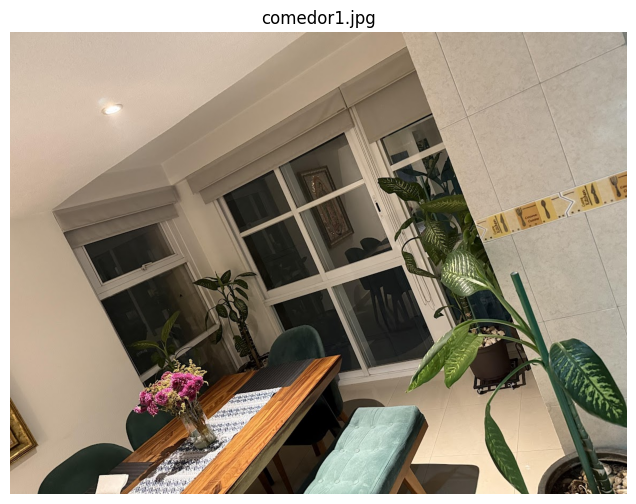

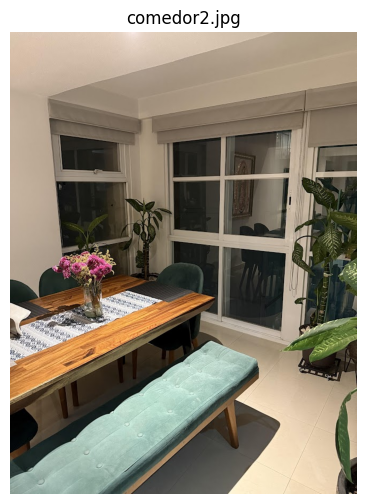

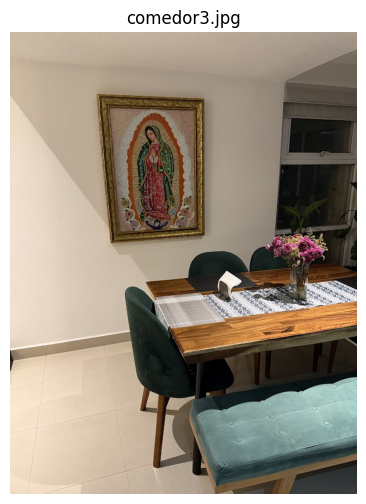

In [3]:
# Mostrar las imágenes con matplotlib
for p in paths:
    img = Image.open(p)
    plt.figure(figsize=(12,6))
    plt.imshow(img)
    plt.title(os.path.basename(p))
    plt.axis('off')
    plt.show()


## Coordenadas de referencia

A continuación, realizamos un ejemplo de selección de puntos de forma interactiva en la imagen 'comedor3.jpg'.
Al ejecutar la siguiente celda, se mostrará la imagen en una ventana emergente.
La idea es seleccionar cuatro puntos haciendo clic en los siguientes lugares:
- Esquina superior izquierda del cuadro.
- Esquina inferior derecha del cuadro.
- Extremo izquierdo de la mesa.
- Extremo derecho de la mesa.


Instrucciones: clic en 4 puntos en el siguiente orden:
 1) Esquina superior del cuadro
 2) Esquina inferior del cuadro
 3) Extremo izquierdo de la mesa
 4) Extremo derecho de la mesa


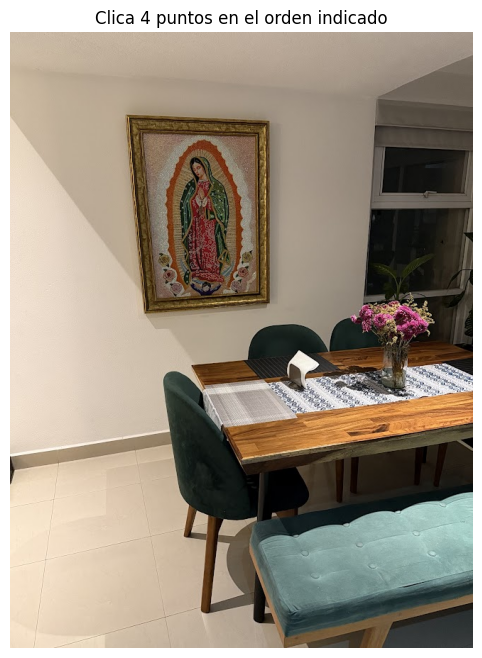

No se recibieron 4 clics vía matplotlib. Intentando fallback con OpenCV (ventana nativa)...
Picture top, bottom: (165, 120) (190, 399)
Table left, right: (258, 464) (333, 603)


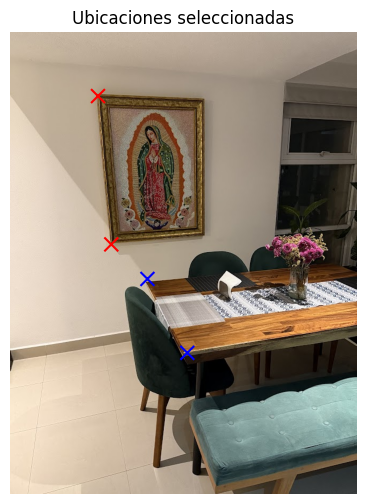

Saved example_coords.json


In [4]:
# Selección interactiva de puntos en la imagen 'comedor3.jpg'
img_path = paths[2]
base = Image.open(img_path)
img_arr = np.array(base)

print("Instrucciones: clic en 4 puntos en el siguiente orden:")
print(" 1) Esquina superior del cuadro")
print(" 2) Esquina inferior del cuadro")
print(" 3) Extremo izquierdo de la mesa")
print(" 4) Extremo derecho de la mesa")

def select_points_mpl(img, n_points=4, title='Clica los puntos'):
    """Intento interactivo con matplotlib + mpl_connect."""
    pts = []
    fig, ax = plt.subplots(figsize=(12,8))
    ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')

    # Callback para registrar clics
    def onclick(event):
        if event.xdata is None or event.ydata is None:
            return
        x, y = int(round(event.xdata)), int(round(event.ydata))
        pts.append((x, y))
        ax.plot(x, y, 'rx', markersize=12)
        fig.canvas.draw()
        # Si ya hay suficientes puntos, desconectar evento
        if len(pts) >= n_points:
            fig.canvas.mpl_disconnect(cid)
            plt.close(fig)

    cid = fig.canvas.mpl_connect('button_press_event', onclick)
    plt.show()
    return pts

def select_points_cv2(img, n_points=4, title='Selecciona puntos (ESC para cancelar)'):
    """Fallback usando ventana OpenCV y callback de ratón (funciona fuera de notebooks)."""
    pts = []
    vis = cv2.cvtColor(img.copy(), cv2.COLOR_RGB2BGR)
    window = 'Select points - ' + title

    def mouse_cb(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            pts.append((x, y))
            cv2.drawMarker(vis, (x, y), (0,0,255), markerType=cv2.MARKER_CROSS, markerSize=20, thickness=2)
            cv2.imshow(window, vis)

    cv2.namedWindow(window, cv2.WINDOW_AUTOSIZE)
    cv2.setMouseCallback(window, mouse_cb)
    cv2.imshow(window, vis)

    # Esperar hasta que el usuario marque 4 puntos o presione ESC
    while True:
        key = cv2.waitKey(1) & 0xFF
        # si se alcanzaron los puntos o ESC (27) -> salir
        if len(pts) >= n_points or key == 27:
            break
        # si se cierra la ventana por el gestor de ventanas -> salir
        if cv2.getWindowProperty(window, cv2.WND_PROP_VISIBLE) < 1:
            break
    cv2.destroyWindow(window)
    return pts

# Primero intentar método matplotlib (funciona en Jupyter clásico con backend interactivo o con ipympl)
points = []
try:
    # Intento interativo con matplolib
    points = select_points_mpl(img_arr, n_points=4, title='Clica 4 puntos en el orden indicado')
except Exception as e:
    print("Error con matplotlib interactivo:", e)

if len(points) < 4:
    print("No se recibieron 4 clics vía matplotlib. Intentando fallback con OpenCV (ventana nativa)...")
    try:
        points = select_points_cv2(img_arr, n_points=4)
    except Exception as e:
        print("Fallback OpenCV falló:", e)

# Si aún no hay 4 puntos, usar valores por defecto
if len(points) < 4:
    print("Selección interactiva falló o incompleta; usando valores por defecto aproximados.")
    picture_top = (int(0.12*1200)+5, int(0.08*800)+5)
    picture_bottom = (picture_top[0]+int(0.75*117*3.0), picture_top[1]+int(117*3.0))
    table_left = (int(0.28*1200), int(0.55*800)+30)
    table_right = (table_left[0]+int(161.1*3.0), table_left[1]+int(161.1*3.0*0.35))
else:
    picture_top, picture_bottom, table_left, table_right = points[0], points[1], points[2], points[3]

print('Picture top, bottom:', picture_top, picture_bottom)
print('Table left, right:', table_left, table_right)

# Mostrar ubicación en la imagen base con los puntos escogidos
plt.figure(figsize=(10,6))
plt.imshow(img_arr)
plt.scatter([picture_top[0], picture_bottom[0]],[picture_top[1], picture_bottom[1]], c=['r','r'], s=100, marker='x')
plt.scatter([table_left[0], table_right[0]],[table_left[1], table_right[1]], c=['b','b'], s=100, marker='x')
plt.title('Ubicaciones seleccionadas')
plt.axis('off')
plt.show()

# Guardar coordenadas
coords = {'picture_top': picture_top, 'picture_bottom': picture_bottom,
          'table_left': table_left, 'table_right': table_right}
with open('../data/original/example_coords.json','w') as f:
    json.dump(coords, f)
print('Saved example_coords.json')


En esta sección añadimos varias pruebas y visualizaciones útiles para entender mejor las imágenes antes de cualquier procesamiento:

In [5]:
# Función para cargar imágenes con OpenCV
def load_image(path):
    # Carga la imagen con OpenCV y devuelve RGB o la matriz en escala de grises si es single-channel.
    img = cv2.imread(str(path), cv2.IMREAD_UNCHANGED)
    if img is None:
        raise FileNotFoundError(f"Imagen no encontrada o formato no soportado: {path}")
    if img.ndim == 2:
        return img
    if img.shape[2] == 4:
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [6]:
def to_gray(img):
    if img.ndim == 2:
        return img
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [7]:
def rms_contrast(gray):
    # Contraste RMS simple: desviación estándar de intensidad
    gray = gray.astype(np.float32)
    return float(np.std(gray))

In [8]:
def edge_count(gray, low=50, high=150):
    edges = cv2.Canny(gray.astype('uint8'), low, high)
    return int(np.count_nonzero(edges)), edges

In [9]:
def count_keypoints_orb(img, nfeatures=500):
    # Detecta y devuelve número de keypoints con ORB (rápido y sin dependencias extra).
    gray = to_gray(img)
    try:
        orb = cv2.ORB_create(nfeatures)
        kps = orb.detect(gray, None)
        return len(kps), kps
    except Exception:
        return 0, []

In [10]:
def hist_per_channel(img, bins=256):
    # Devuelve histogramas por canal para imagen RGB o solo para un canal si grayscale.
    if img.ndim == 2:
        h, _ = np.histogram(img.ravel(), bins=bins, range=(0,255))
        return {'gray': h}
    else:
        hs = {}
        for i, name in enumerate(['r','g','b']):
            h, _ = np.histogram(img[:,:,i].ravel(), bins=bins, range=(0,255))
            hs[name] = h
        return hs

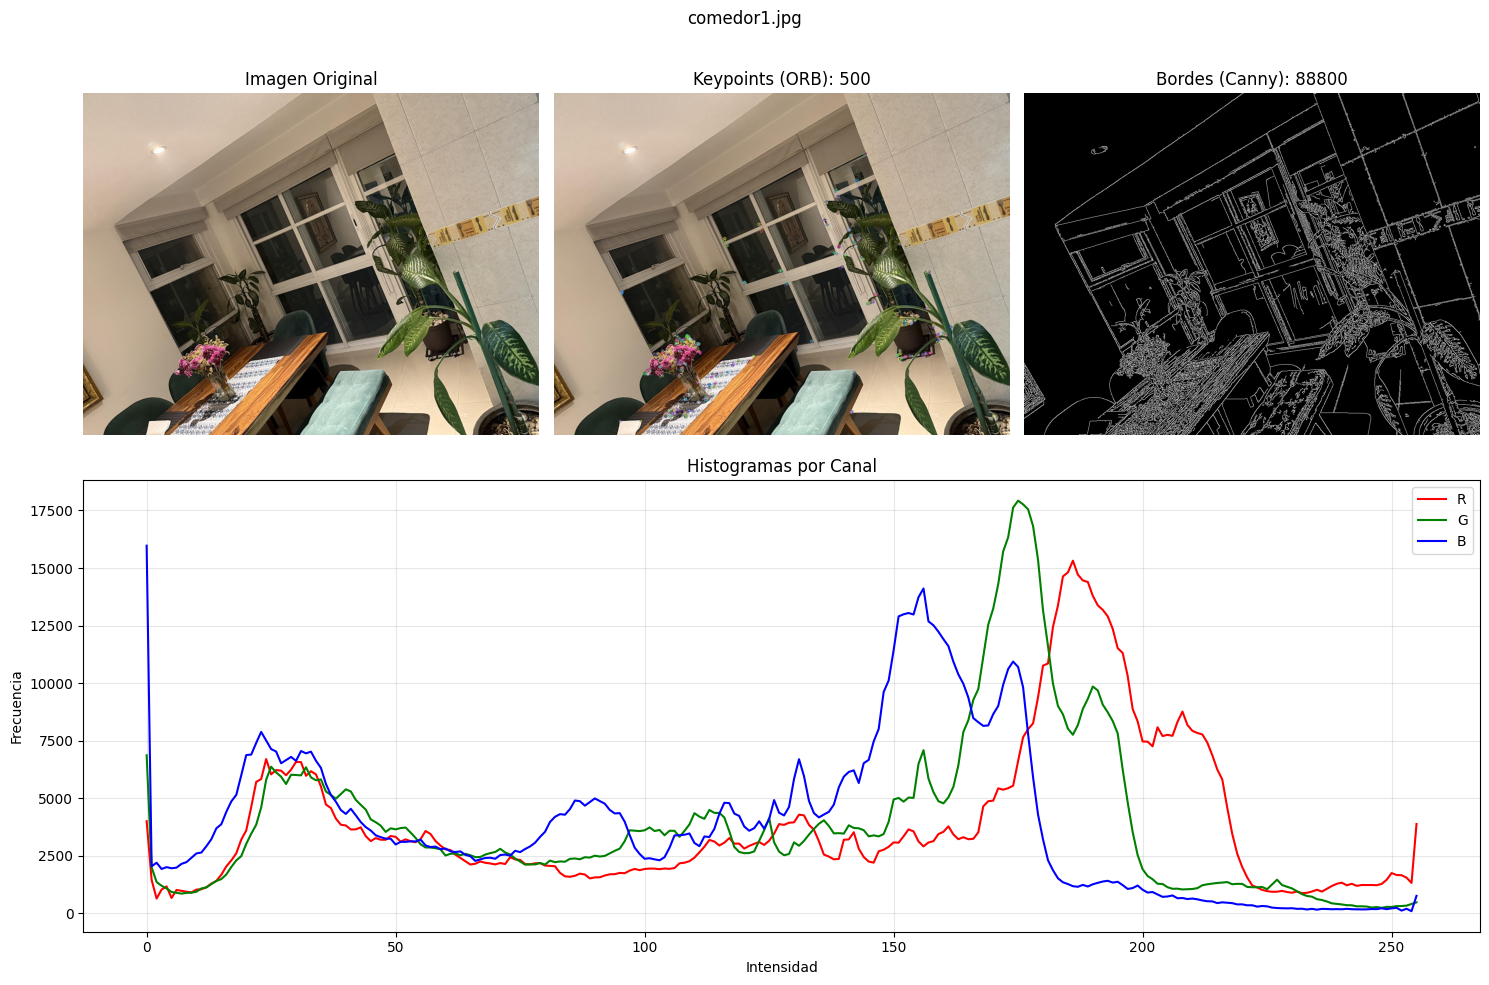

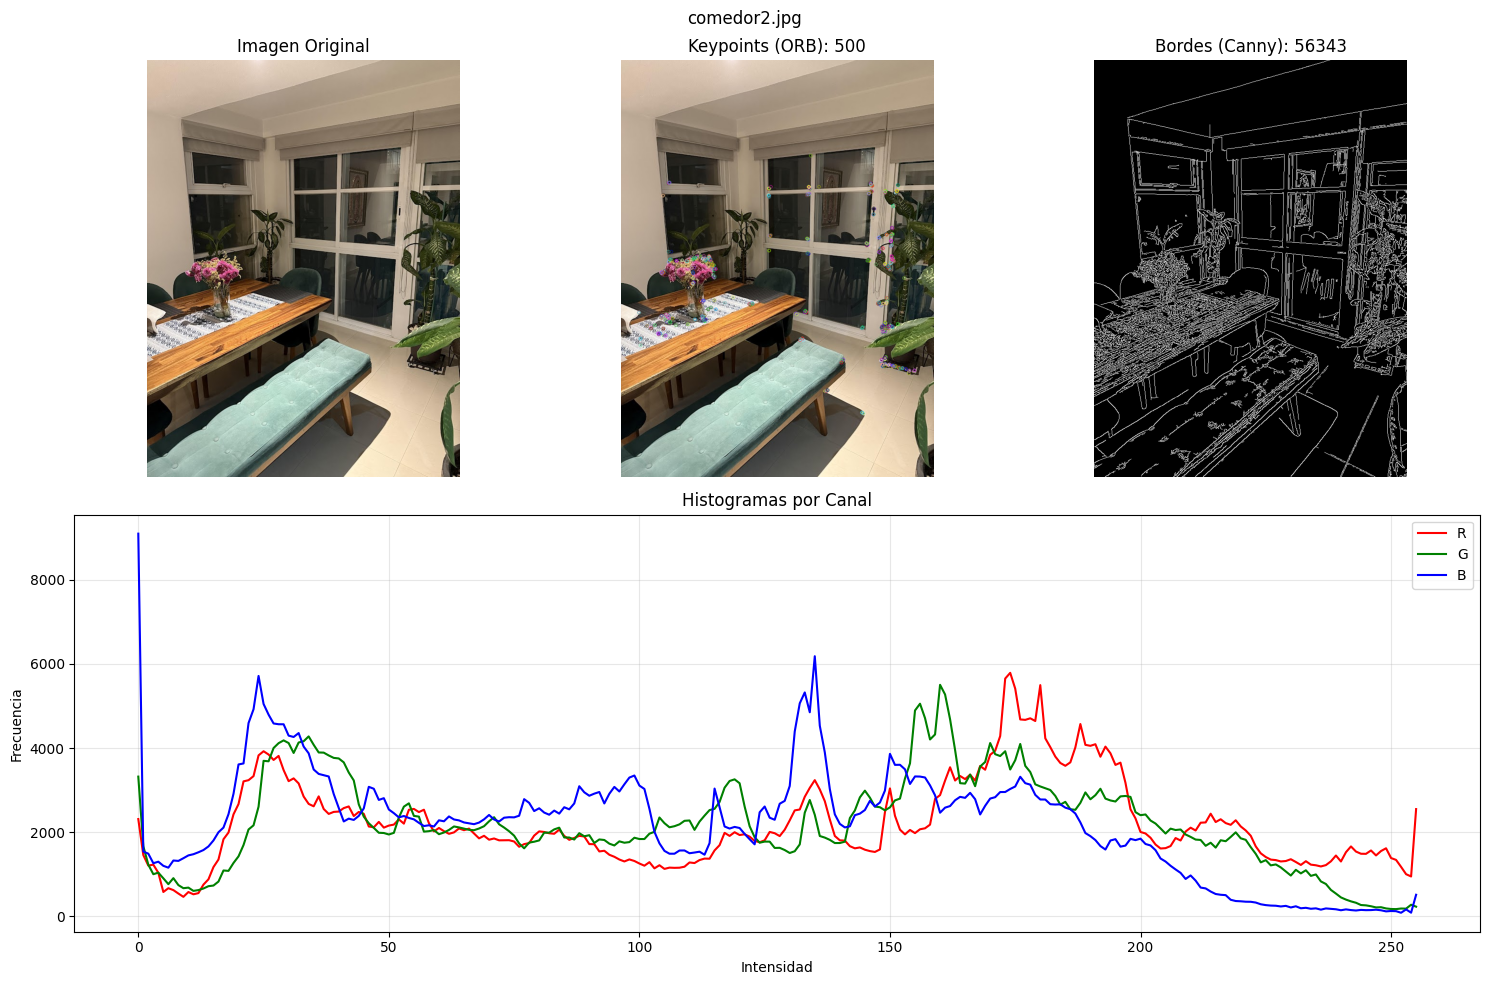

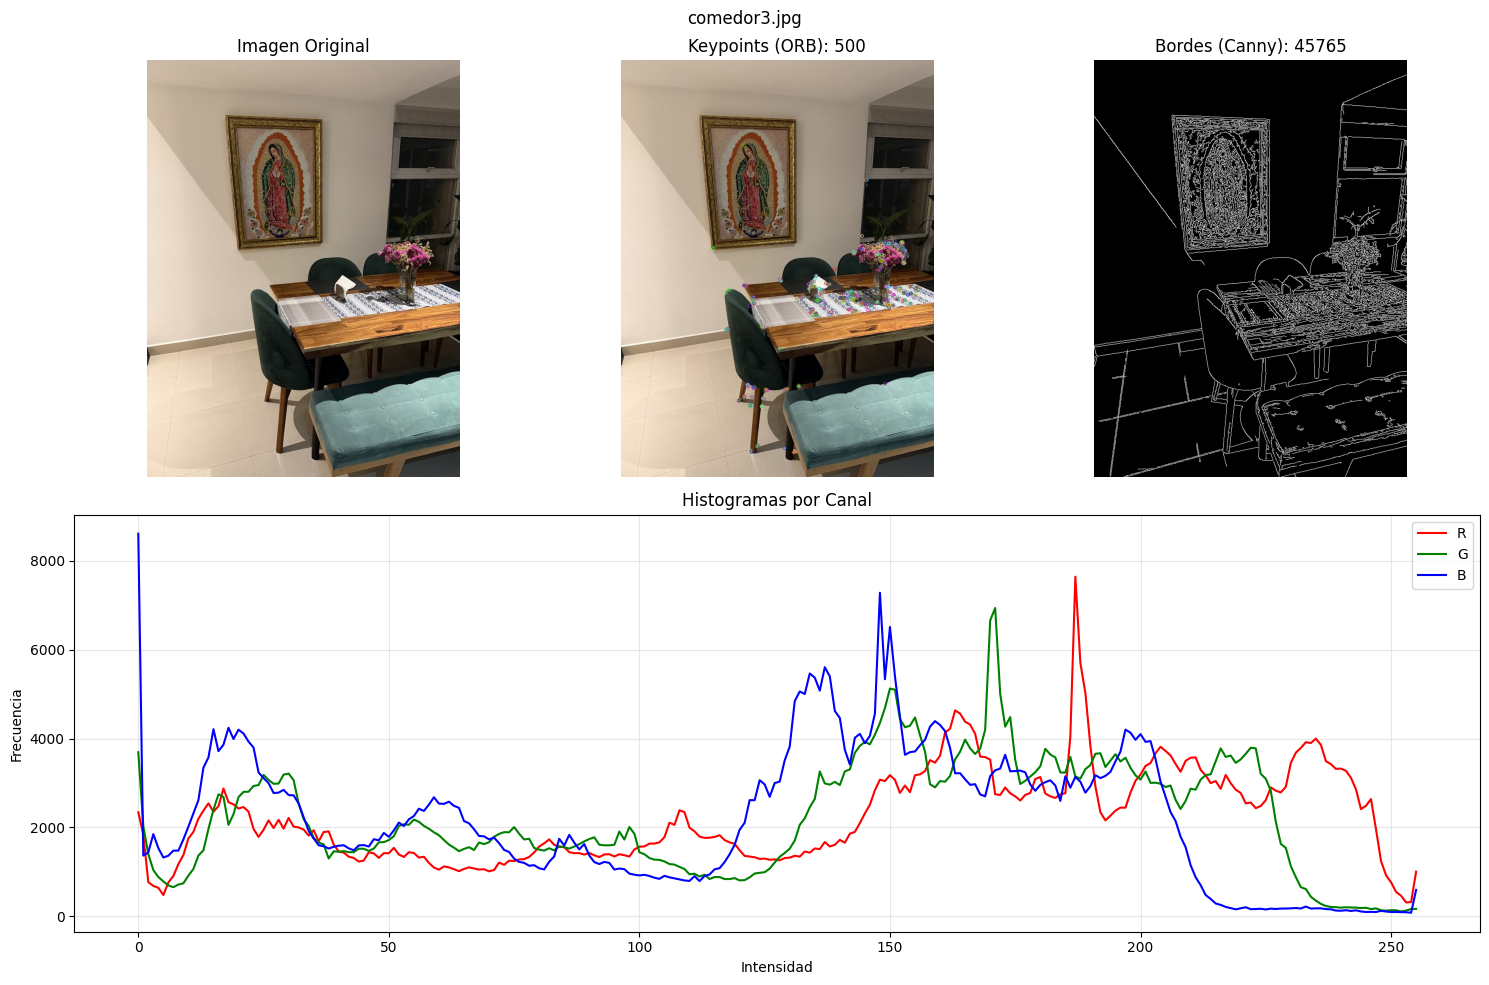

Resumen guardado en ../data/exploratory_image_summary.csv


In [11]:
# Análisis automático de todas las imágenes en 'data' (recursivo)
rows = []
for p in paths:
    try:
        img = load_image(p)
    except Exception as e:
        rows.append({'file': p, 'error': str(e)})
        continue
        
    # Análisis básico
    gray = to_gray(img)
    h, w = (gray.shape[0], gray.shape[1])
    mean = float(np.mean(gray))
    std = float(np.std(gray))
    mn = int(np.min(gray))
    mx = int(np.max(gray))
    rms = rms_contrast(gray)
    edges_n, edges_img = edge_count(gray)
    kp_count, kps = count_keypoints_orb(img)
    
    # Obtener histogramas
    histograms = hist_per_channel(img)
    
    # Visualización
    plt.figure(figsize=(15, 10))
    plt.suptitle(os.path.basename(p))
    
    # Imagen original
    plt.subplot(2, 3, 1)
    plt.title('Imagen Original')
    plt.imshow(img)
    plt.axis('off')
    
    # Keypoints
    plt.subplot(2, 3, 2)
    vis = img.copy() if img.ndim==3 else np.stack([img]*3, axis=-1)
    try:
        vis_kp = cv2.drawKeypoints(cv2.cvtColor(vis, cv2.COLOR_RGB2BGR), kps, None)
        vis_kp = cv2.cvtColor(vis_kp, cv2.COLOR_BGR2RGB)
    except Exception:
        vis_kp = vis
    plt.title(f'Keypoints (ORB): {kp_count}')
    plt.imshow(vis_kp)
    plt.axis('off')
    
    # Bordes
    plt.subplot(2, 3, 3)
    plt.title(f'Bordes (Canny): {edges_n}')
    plt.imshow(edges_img, cmap='gray')
    plt.axis('off')
    
    # Histogramas
    plt.subplot(2, 1, 2)
    plt.title('Histogramas por Canal')
    if img.ndim == 2:
        plt.plot(histograms['gray'], color='gray', label='Intensidad')
    else:
        for color, hist in histograms.items():
            plt.plot(hist, color=color, label=color.upper())
    plt.xlabel('Intensidad')
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Agregar datos al resumen
    rows.append({
        'file': p,
        'height': h, 'width': w, 'channels': (1 if img.ndim==2 else 3),
        'mean_intensity': mean, 'std_intensity': std, 'min': mn, 'max': mx,
        'rms_contrast': rms, 'edge_pixels': edges_n, 'keypoint_count': kp_count
    })

df_summary = pd.DataFrame(rows)
# display_dataframe_to_user('Resumen exploratorio de imágenes', df_summary)
df_summary.to_csv('../data/exploratory_image_summary.csv', index=False)
print('Resumen guardado en ../data/exploratory_image_summary.csv')

# Conclusiones

- Las imágenes del conjunto tienen suficiente textura y puntos clave detectables (ORB funciona rápido; usar SIFT mejora robustez ante cambios de escala/rotación). Esto permite un registro confiable en la mayoría de las escenas interiores.

- Se guardaron coordenadas de referencia de ejemplo en `../data/original/example_coords.json`. Este mismo uso interactivo sera usado nuevamente en los siguientes notebooks.